## 1. Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk import word_tokenize
from nltk.corpus import brown as cb

import pprint

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten, GlobalAveragePooling1D, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## 2. Loading of Brown Corpus Dataset from NLTK Library

In [2]:
tagged_sentences = cb.tagged_sents(tagset = 'universal')
print(len(tagged_sentences))

57340


## 3. Preprocessing

### Untagging input into words and respective Tags

In [3]:
def untag_sentences(tagged_sentences):
    X = [] # input
    Y = [] # expected output
    
    for sentence in tagged_sentences:
        X_sentence = []
        Y_sentence = []
        for entity in sentence:         
            X_sentence.append(entity[0])  # contains the word
            Y_sentence.append(entity[1])  # contains corresponding tag

        X.append(X_sentence)
        Y.append(Y_sentence)
    
    num_words = len(set([word.lower() for sentence in X for word in sentence]))
    num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

    print(set([word for sentence in Y for word in sentence]))
    print("Total number of tagged sentences: ",len(X))
    print("Vocabulary size: ", num_words)
    print("Total number of tags: ", num_tags)
    
    return X, Y

In [4]:
X, Y = untag_sentences(tagged_sentences)

{'ADV', 'CONJ', 'NUM', 'VERB', 'PRON', 'X', 'ADJ', '.', 'PRT', 'ADP', 'DET', 'NOUN'}
Total number of tagged sentences:  57340
Vocabulary size:  49815
Total number of tags:  12


### Sample Datapoint

In [5]:
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], '\n')

print("Length of first input sequence: ", len(X[0]))
print("Length of first output sequence: ", len(Y[0]))

sample X:  ['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'] 

sample Y:  ['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.'] 

Length of first input sequence:  25
Length of first output sequence:  25


### Tokenizing Input and Expected Output

In [6]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X)
X_encoded = word_tokenizer.texts_to_sequences(X)

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
TAGS = {v: k for k, v in tag_tokenizer.word_index.items()}
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [7]:
pprint.pprint(TAGS)

{1: 'noun',
 2: 'verb',
 3: '.',
 4: 'adp',
 5: 'det',
 6: 'adj',
 7: 'adv',
 8: 'pron',
 9: 'conj',
 10: 'prt',
 11: 'num',
 12: 'x'}


### Sample Datapoint

In [8]:
print("RAW DATA SAMPLE", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')

print()
print("ENCODED DATA SAMPLE", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

RAW DATA SAMPLE 
 ---------------------------------------------------------------------------------------------------- 

X:  ['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'] 

Y:  ['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.'] 


ENCODED DATA SAMPLE 
 ---------------------------------------------------------------------------------------------------- 

X:  [1, 5433, 651, 2296, 1634, 62, 1846, 35, 2177, 4, 14222, 551, 1120, 1401, 1193, 14, 59, 473, 15, 9, 85, 9199, 213, 171, 3] 

Y:  [5, 1, 1, 6, 1, 2, 1, 5, 1, 4, 1, 6, 1, 1, 2, 3, 5, 1, 3, 4, 5, 1, 2, 1, 3] 



### Padding

In [9]:
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: ", max(lengths))

max_length = max(lengths)
trunc_type = 'post'
pad_type = 'post'

X_padded = pad_sequences(X_encoded, maxlen=max_length, truncating=trunc_type, padding=pad_type)
Y_padded = pad_sequences(Y_encoded, maxlen=max_length, truncating=trunc_type, padding=pad_type, value = -1)

Length of longest sentence:  180


### One Hot Encoding the Expected Output

In [10]:
Y = to_categorical(Y_padded)

### Splitting Data into Training, Testing and Validation Set

In [11]:
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X_padded, Y, test_size=TEST_SIZE, shuffle=False)

VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, \
                                                                shuffle=False)

In [12]:
print("Number of Training Instances: ", len(X_train))
print("Number of Testing Instances: ", len(X_test))
print("Number of Validation Instances: ", len(X_validation))

Number of Training Instances:  41428
Number of Testing Instances:  8601
Number of Validation Instances:  7311


In [13]:
print("TRAINING DATA")
print('Shape of input sequences: ', X_train.shape)
print('Shape of output sequences: ', Y_train.shape)
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: ', X_validation.shape)
print('Shape of output sequences: ', Y_validation.shape)
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: ', X_test.shape)
print('Shape of output sequences: ', Y_test.shape)

TRAINING DATA
Shape of input sequences:  (41428, 180)
Shape of output sequences:  (41428, 180, 13)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences:  (7311, 180)
Shape of output sequences:  (7311, 180, 13)
--------------------------------------------------
TESTING DATA
Shape of input sequences:  (8601, 180)
Shape of output sequences:  (8601, 180, 13)


## 3. Model

### Model Creation

In [14]:
embedding_dim = 300
vocab_size = len(word_tokenizer.word_index) + 1
num_classes = Y.shape[2]

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(32, return_sequences=True))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(num_classes, activation='softmax'))

2021-10-27 06:16:03.151650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 06:16:03.248883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 06:16:03.249723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 06:16:03.251600: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

### Model Compilation

In [15]:
optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
model.compile(
    loss = "categorical_crossentropy",
    optimizer = optimizer,
    metrics = ["accuracy"]
)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 180, 300)          14944800  
_________________________________________________________________
lstm (LSTM)                  (None, 180, 32)           42624     
_________________________________________________________________
dense (Dense)                (None, 180, 32)           1056      
_________________________________________________________________
dense_1 (Dense)              (None, 180, 16)           528       
_________________________________________________________________
dense_2 (Dense)              (None, 180, 13)           221       
Total params: 14,989,229
Trainable params: 14,989,229
Non-trainable params: 0
_________________________________________________________________


### Callbacks and Early Stopping

In [17]:
filepath = 'my_checkpoint.ckpt'
cp = ModelCheckpoint(
    filepath=filepath,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1
)

ep = EarlyStopping(
    monitor='val_accuracy', 
    patience=3,
)

### Training

In [18]:
history = model.fit(X_train, Y_train,
                    batch_size=128,
                    epochs=30,
                    validation_data=(X_validation, Y_validation),
                    callbacks=[cp,ep]
                   )

2021-10-27 06:16:07.276938: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2021-10-27 06:16:09.611725: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


324/324 [==============================] - 10s 21ms/step - loss: 1.4751 - accuracy: 0.5568 - val_loss: 0.3840 - val_accuracy: 0.9171

Epoch 00001: val_accuracy improved from -inf to 0.91710, saving model to my_checkpoint.ckpt
Epoch 2/30
324/324 [==============================] - 6s 19ms/step - loss: 0.3633 - accuracy: 0.8852 - val_loss: 0.2273 - val_accuracy: 0.9289

Epoch 00002: val_accuracy improved from 0.91710 to 0.92891, saving model to my_checkpoint.ckpt
Epoch 3/30
324/324 [==============================] - 6s 19ms/step - loss: 0.2912 - accuracy: 0.9027 - val_loss: 0.1788 - val_accuracy: 0.9440

Epoch 00003: val_accuracy improved from 0.92891 to 0.94402, saving model to my_checkpoint.ckpt
Epoch 4/30
324/324 [==============================] - 6s 19ms/step - loss: 0.2157 - accuracy: 0.9367 - val_loss: 0.1284 - val_accuracy: 0.9666

Epoch 00004: val_accuracy improved from 0.94402 to 0.96661, saving model to my_checkpoint.ckpt
Epoch 5/30
324/324 [==============================] - 6s 

## 4. Graphs

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


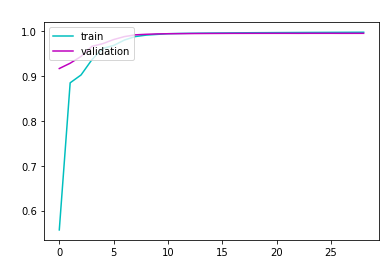

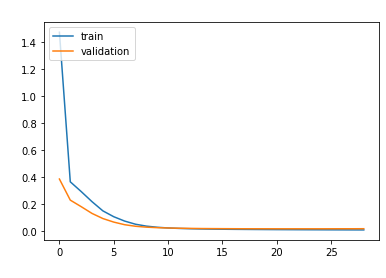

In [19]:
print(history.history.keys())
plt.axes().set(facecolor ="white")
plt.plot(history.history['accuracy'],color='c')
plt.plot(history.history['val_accuracy'],color='m')
plt.title('model accuracy').set_color('white')
plt.ylabel('accuracy').set_color('white')
plt.xlabel('epoch').set_color('white')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

plt.axes().set(facecolor ="white")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left')
plt.title('model loss').set_color('white')
plt.ylabel('loss').set_color('white')
plt.xlabel('epoch').set_color('white')
plt.show()

## 5. Accuracy and Loss

In [20]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: ", loss)
print("Accuracy: %0.2f%%"%(accuracy * 100))

269/269 [==============================] - 1s 5ms/step - loss: 0.0175 - accuracy: 0.9950
Loss:  0.01754867285490036
Accuracy: 99.50%


## 6. Applying model to predict new instances

In [21]:
def generate_POS_tags(orig_sentence):
    orig_sentence = [orig_sentence.split(" ")]
    sentence = word_tokenizer.texts_to_sequences(orig_sentence)
    sentence = pad_sequences(sentence, maxlen=max_length, truncating=trunc_type, padding=pad_type)
    
    predict_x=model.predict(sentence[0]) 
    pos = []
    for i in range(len(orig_sentence[0])):
        index = np.argmax(predict_x[i], axis=1)
        pos.append(TAGS[index[0]].upper())
        
    return list(zip(orig_sentence[0],pos))

In [22]:
sent = " ".join(X[10])
print(sent)
res = generate_POS_tags(sent)
pprint.pprint(res)
pprint.pprint(tagged_sentences[10])

It urged that the city `` take steps to remedy '' this problem .
[('It', 'PRON'),
 ('urged', 'VERB'),
 ('that', 'DET'),
 ('the', 'DET'),
 ('city', 'NOUN'),
 ('``', '.'),
 ('take', 'VERB'),
 ('steps', 'NOUN'),
 ('to', 'ADP'),
 ('remedy', 'NOUN'),
 ("''", '.'),
 ('this', 'DET'),
 ('problem', 'NOUN'),
 ('.', '.')]
[('It', 'PRON'),
 ('urged', 'VERB'),
 ('that', 'ADP'),
 ('the', 'DET'),
 ('city', 'NOUN'),
 ('``', '.'),
 ('take', 'VERB'),
 ('steps', 'NOUN'),
 ('to', 'PRT'),
 ('remedy', 'VERB'),
 ("''", '.'),
 ('this', 'DET'),
 ('problem', 'NOUN'),
 ('.', '.')]


In [23]:
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

inp = "I am driving the car to the store today"
res = generate_POS_tags(inp)
pprint.pprint(res)
pos_tag(word_tokenize(inp), tagset='universal')

[('I', 'PRON'),
 ('am', 'VERB'),
 ('driving', 'VERB'),
 ('the', 'DET'),
 ('car', 'NOUN'),
 ('to', 'ADP'),
 ('the', 'DET'),
 ('store', 'NOUN'),
 ('today', 'NOUN')]


[('I', 'PRON'),
 ('am', 'VERB'),
 ('driving', 'VERB'),
 ('the', 'DET'),
 ('car', 'NOUN'),
 ('to', 'PRT'),
 ('the', 'DET'),
 ('store', 'NOUN'),
 ('today', 'NOUN')]

In [24]:
inp = "Now you're just somebody that I used to know"
res = generate_POS_tags(inp)
pprint.pprint(res)
pos_tag(word_tokenize(inp), tagset='universal')

[('Now', 'ADV'),
 ("you're", 'PRT'),
 ('just', 'ADV'),
 ('somebody', 'NOUN'),
 ('that', 'DET'),
 ('I', 'PRON'),
 ('used', 'VERB'),
 ('to', 'ADP'),
 ('know', 'VERB')]


[('Now', 'ADV'),
 ('you', 'PRON'),
 ("'re", 'VERB'),
 ('just', 'ADV'),
 ('somebody', 'NOUN'),
 ('that', 'ADP'),
 ('I', 'PRON'),
 ('used', 'VERB'),
 ('to', 'PRT'),
 ('know', 'VERB')]

In [25]:
inp = "The market is projected to crash within the next month"
res = generate_POS_tags(inp)
pprint.pprint(res)
pos_tag(word_tokenize(inp), tagset='universal')

[('The', 'DET'),
 ('market', 'NOUN'),
 ('is', 'VERB'),
 ('projected', 'VERB'),
 ('to', 'ADP'),
 ('crash', 'NOUN'),
 ('within', 'ADP'),
 ('the', 'DET'),
 ('next', 'ADJ'),
 ('month', 'NOUN')]


[('The', 'DET'),
 ('market', 'NOUN'),
 ('is', 'VERB'),
 ('projected', 'VERB'),
 ('to', 'PRT'),
 ('crash', 'VERB'),
 ('within', 'ADP'),
 ('the', 'DET'),
 ('next', 'ADJ'),
 ('month', 'NOUN')]